# An example of using regression

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *

In [4]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [5]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/07.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/11.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/04'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/23.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/24'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/24.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/15.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/03'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/13'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/17.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/20.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/09.obj'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/01'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/10'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/11'),
 PosixPath('/home/jupyter/.fastai/data/biwi_head_pose/readme.txt'),


In [6]:
print(path/'readme.txt')

/home/jupyter/.fastai/data/biwi_head_pose/readme.txt


In [7]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6);
cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [8]:
fname = '09/frame_00667_rgb.jpg'

In [12]:
def img2_txtname(f):
    return path/f'{str(f)[:-7]}pose.txt'

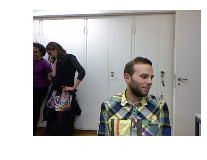

In [10]:
img = open_image(path/fname)
img.show()

In [13]:
ctr = np.genfromtxt(img2_txtname(fname), skip_header=3)
ctr

array([187.332 ,  40.3892, 893.135 ])

In [15]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2_txtname(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [16]:
get_ctr(fname)

tensor([263.9104, 428.5814])

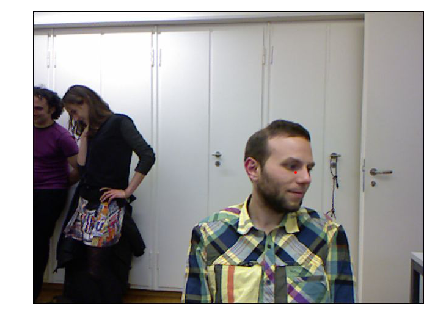

In [17]:
ctr = get_ctr(fname)
img.show(y = get_ip(img, ctr), figsize = (7,7))

# Create a dataset/databunch

In [20]:
data = (ImageItemList.from_folder(path)
       .split_by_valid_func(lambda o: o.parent.name == '13')
       .label_from_func(get_ctr, label_cls = PointsItemList)
       .transform(get_transforms(), tfm_y = True, size = (120,160))
       .databunch().normalize(imagenet_stats)
       )

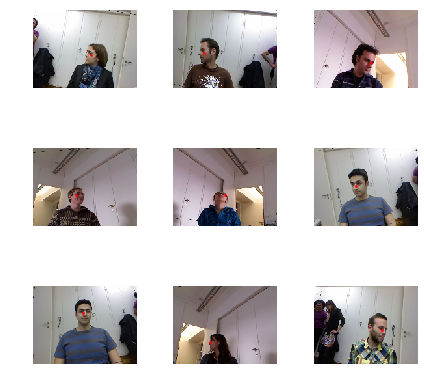

In [22]:
data.show_batch(3, figsize = (6,6))

# Train the Model

In [23]:
learn = create_cnn(data, models.resnet34)

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


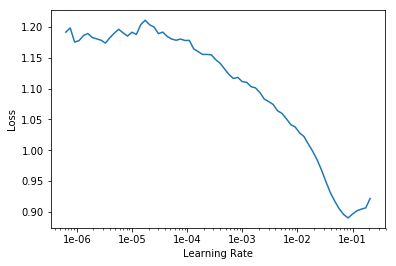

In [26]:
learn.recorder.plot()

In [27]:
lr = 1e-2

In [28]:
learn.fit_one_cycle(5, slice(lr))

Total time: 03:15
epoch  train_loss  valid_loss
1      0.044343    0.009924    (00:38)
2      0.021022    0.005145    (00:39)
3      0.008455    0.004878    (00:39)
4      0.004371    0.002263    (00:39)
5      0.003269    0.001212    (00:39)



In [29]:
learn.save('stage-1')

In [31]:
learn.load('stage-1');

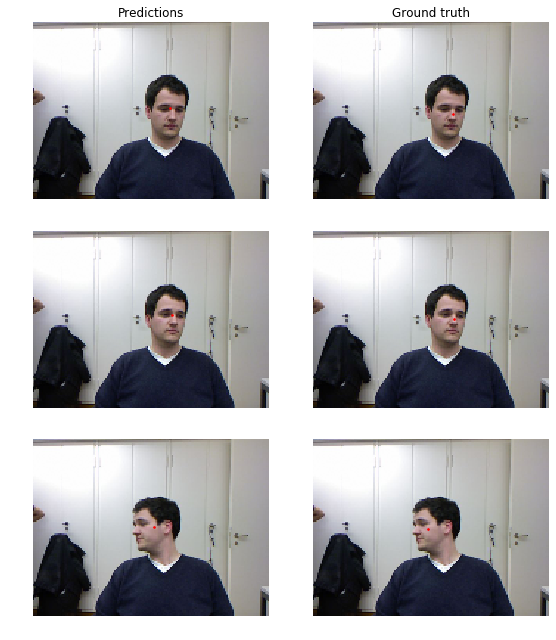

In [32]:
learn.show_results()